
# 0. Imports


In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

In [26]:
# =========================
# 1. File paths
# =========================
gnaf_path = r"C:\Users\shiva\Downloads\gnaf_prop.parquet"
roads_path = r"C:\Users\shiva\Downloads\roads.gpkg"

In [28]:
# =========================
# 2. Load data
# =========================

# Loading GNAF properties (must contain 'latitude' and 'longitude' columns)
gnaf = pd.read_parquet(gnaf_path)

print("GNAF columns:", gnaf.columns.tolist())

# Keeping original lat/lon in degrees for output
gnaf["lat_deg"] = gnaf["latitude"]
gnaf["lon_deg"] = gnaf["longitude"]


GNAF columns: ['gid', 'gnaf_pid', 'street_locality_pid', 'locality_pid', 'alias_principal', 'primary_secondary', 'building_name', 'lot_number', 'flat_number', 'level_number', 'number_first', 'number_last', 'street_name', 'street_type', 'street_suffix', 'address', 'locality_name', 'postcode', 'state', 'locality_postcode', 'confidence', 'legal_parcel_id', 'mb_2016_code', 'mb_2021_code', 'latitude', 'longitude', 'geocode_type', 'reliability', 'geom', 'schema']


In [30]:
# Loading roads layer
roads = gpd.read_file(roads_path)
print("Roads CRS before:", roads.crs)

Roads CRS before: EPSG:4326


In [32]:
# =========================
# 3. Creating GeoDataFrames and set CRS
# =========================

# Properties as GeoDataFrame in WGS84
gdf_props = gpd.GeoDataFrame(
    gnaf,
    geometry=gpd.points_from_xy(gnaf["longitude"], gnaf["latitude"]),
    crs="EPSG:4326"   # lat/lon
)

# Reprojected both to a metric CRS for distance in metres
gdf_props = gdf_props.to_crs("EPSG:3857")
roads = roads.to_crs("EPSG:3857")

print("Props CRS:", gdf_props.crs)
print("Roads CRS:", roads.crs)


Props CRS: EPSG:3857
Roads CRS: EPSG:3857


In [34]:
# =========================
# 4. Helper functions
# =========================

def nearest_road_geom(point):
    """
    For a given property point, find the nearest road geometry
    by computing distances to all roads and taking the minimum.
    Good enough for a sample of a few thousand points.
    """
    dists = roads.geometry.distance(point)
    nearest_idx = dists.idxmin()
    return roads.geometry.iloc[nearest_idx]

def compute_bearing(line):
    """
    Compute a simple bearing for a road segment using
    the first and last coordinate pair.

    Bearing returned in degrees, 0–360, where:
    0/360 ≈ North, 90 ≈ East, 180 ≈ South, 270 ≈ West.
    """
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]

    dx = x2 - x1
    dy = y2 - y1

    angle = np.degrees(np.arctan2(dx, dy))
    bearing = (angle + 360) % 360
    return bearing

def direction_from_bearing(b):
    """
    Map numeric bearing to 8-way compass direction.
    """
    bands = [
        ("North", 0, 22.5),
        ("North East", 22.5, 67.5),
        ("East", 67.5, 112.5),
        ("South East", 112.5, 157.5),
        ("South", 157.5, 202.5),
        ("South West", 202.5, 247.5),
        ("West", 247.5, 292.5),
        ("North West", 292.5, 337.5),
        ("North", 337.5, 360),
    ]
    for name, low, high in bands:
        if low <= b < high:
            return name


In [36]:
# =========================
# 5. Sample properties for processing (for speed)
# =========================

sample_size = 2000      # change if you want more/less
sample = gdf_props.sample(sample_size, random_state=0)
print(f"Processing sample of {len(sample)} properties")


Processing sample of 2000 properties


In [38]:
# =========================
# 6. Main loop: nearest road + orientation
# =========================

orientations = []

for idx, row in sample.iterrows():
    point = row.geometry

    road_geom = nearest_road_geom(point)
    if road_geom is None or road_geom.is_empty:
        continue

    bearing = compute_bearing(road_geom)
    direction = direction_from_bearing(bearing)

    orientations.append({
        # IMPORTANT: change "address" below if your column is named differently in GNAF
        "address": row.get("address", None),
        "latitude": row["lat_deg"],      # original degrees
        "longitude": row["lon_deg"],     # original degrees
        "orientation": direction,
    })

df_out = pd.DataFrame(orientations)

print(df_out.head())
print("Rows in output:", len(df_out))


               address   latitude   longitude orientation
0      7 WALTER STREET -33.812059  151.198644        West
1       5 BABBAGE ROAD -33.779241  151.195728        East
2  31 TRAFALGAR AVENUE -33.778921  151.175919        East
3     14 FOURTH AVENUE -33.801236  151.209488        East
4  34 PENSHURST STREET -33.803965  151.197591        East
Rows in output: 2000


In [39]:
# 7. Saveing the output CSV
# =========================

output_path = r"C:\Users\shiva\Downloads\property_orientation_sample.csv"
df_out.to_csv(output_path, index=False)
print("Saved to:", output_path)

Saved to: C:\Users\shiva\Downloads\property_orientation_sample.csv


In [47]:
df_out.head(50)

,address,latitude,longitude,orientation
0,7 WALTER STREET,-33.812059,151.198644,West
1,5 BABBAGE ROAD,-33.779241,151.195728,East
2,31 TRAFALGAR AVENUE,-33.778921,151.175919,East
3,14 FOURTH AVENUE,-33.801236,151.209488,East
4,34 PENSHURST STREET,-33.803965,151.197591,East
5,333 SAILORS BAY ROAD,-33.811681,151.218764,East
6,9 HILL STREET,-33.784769,151.179051,East
7,"UNIT 10, 587-589 WILLOUGHBY ROAD",-33.804909,151.199631,East
8,27 WARRANE ROAD,-33.794639,151.205477,East
9,"UNIT 67, 79-113 SAILORS BAY ROAD",-33.810060,151.208793,West


In [51]:
df_out[df_out["orientation"] == "North"].head(20)


,address,latitude,longitude,orientation
28,11 NEERIM ROAD,-33.782618,151.208832,North
30,3 PARNOO AVENUE,-33.783925,151.209798,North
34,11 THE BARBICAN,-33.803242,151.220749,North
41,15A HOLLY STREET,-33.779906,151.205872,North
81,91 NEERIM ROAD,-33.786097,151.214938,North
82,13 HOLLY STREET,-33.780126,151.205861,North
89,101 NEERIM ROAD,-33.786533,151.215966,North
91,274 BOUNDARY STREET,-33.779264,151.207834,North
107,3 MORELLA PLACE,-33.788639,151.221580,North
124,76 BABBAGE ROAD,-33.776046,151.205760,North


In [53]:
df_out[df_out["orientation"] == "North"].shape[0]


104

In [59]:
print(df_out[df_out["orientation"] == "North"].shape[0])
print(df_out[df_out["orientation"] == "North East"].shape[0])
print(df_out[df_out["orientation"] == "North West"].shape[0])


104
66
4


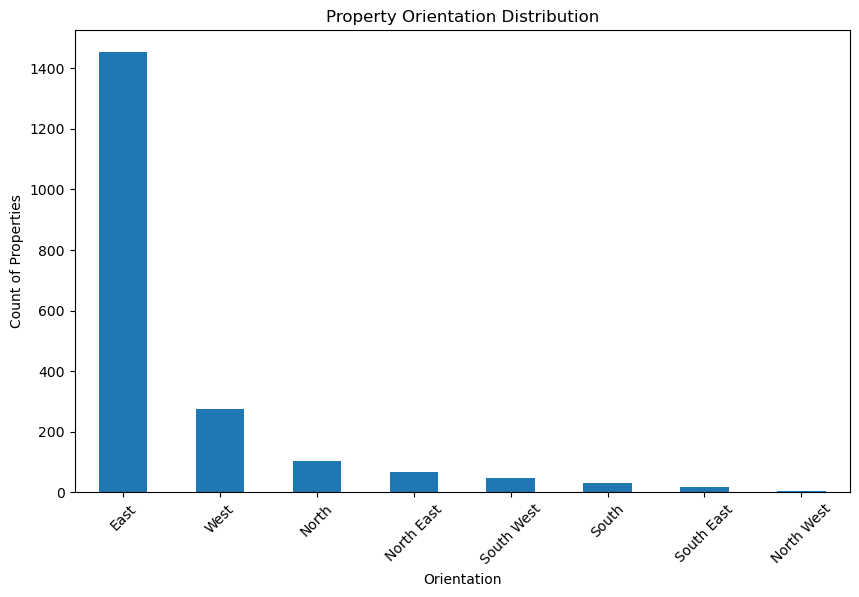

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df_out["orientation"].value_counts().plot(kind="bar")
plt.title("Property Orientation Distribution")
plt.xlabel("Orientation")
plt.ylabel("Count of Properties")
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x1000 with 0 Axes>

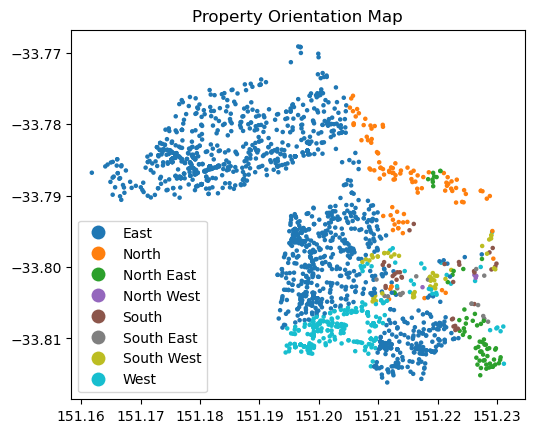

In [63]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Creating GeoDataFrame from df_out
gdf_plot = gpd.GeoDataFrame(
    df_out,
    geometry=gpd.points_from_xy(df_out["longitude"], df_out["latitude"]),
    crs="EPSG:4326"
)

plt.figure(figsize=(10,10))
gdf_plot.plot(column="orientation", legend=True, markersize=5)
plt.title("Property Orientation Map")
plt.show()


<Figure size 1000x1000 with 0 Axes>

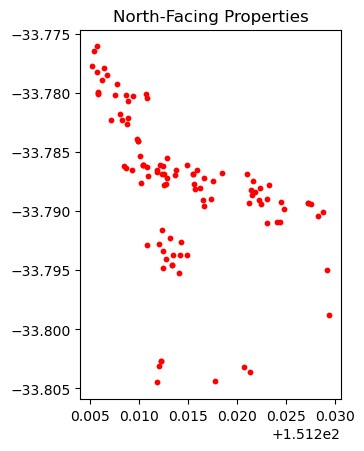

In [65]:
north_homes = gdf_plot[gdf_plot["orientation"] == "North"]

plt.figure(figsize=(10,10))
north_homes.plot(color="red", markersize=10)
plt.title("North-Facing Properties")
plt.show()
